In [3]:
# import packages
import sys, os
sys.path.insert(0, os.path.abspath('/home/reilly/ai_scientist_project'))
import numpy as np
import optax
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import inspect
# import local modules
import utils, diagnostic, loss_functions, seed_programs, hypothesis_engine

In [4]:
conc_thresh, activity_thresh = 0.45, 0.45 # thresholds for conc and activity
data_dir = '/home/reilly/Downloads/8279387/gratings_drifting_GT1_2019_04_12_1.npy'
neural_data = np.load(data_dir, allow_pickle=True)
neural_data = neural_data.item()
response = utils.extract_stimulus_related_response(neural_data, n_pcs=0)
angles = neural_data['istim']
n_trials = response.shape[1]

# filter 
active = (response > 0).astype(np.float32)
firing_probs = np.mean(active, axis=1)
conc = np.abs(np.sum(np.exp(2j * angles)[np.newaxis, :] * response, axis=1) / np.sum(response, axis=1))
good_cells = np.where((firing_probs > activity_thresh) & (conc > conc_thresh))[0]
n_good_cells = len(good_cells)
print(f'Number of good cells: {n_good_cells} out of {response.shape[0]}')

# crop to good cells
if n_good_cells % 2 != 0:
    good_cells = good_cells[:-1]  # ensure even number of cells
    print(f'Adjusted number of good cells to {len(good_cells)} for evenness.')
response = response[good_cells, :]
response = jnp.asarray(response)
angles = jnp.asarray(angles)
n_cells, n_trials = response.shape

Number of good cells: 2218 out of 20616


# Part 1: Estimating Empirical Spectrum

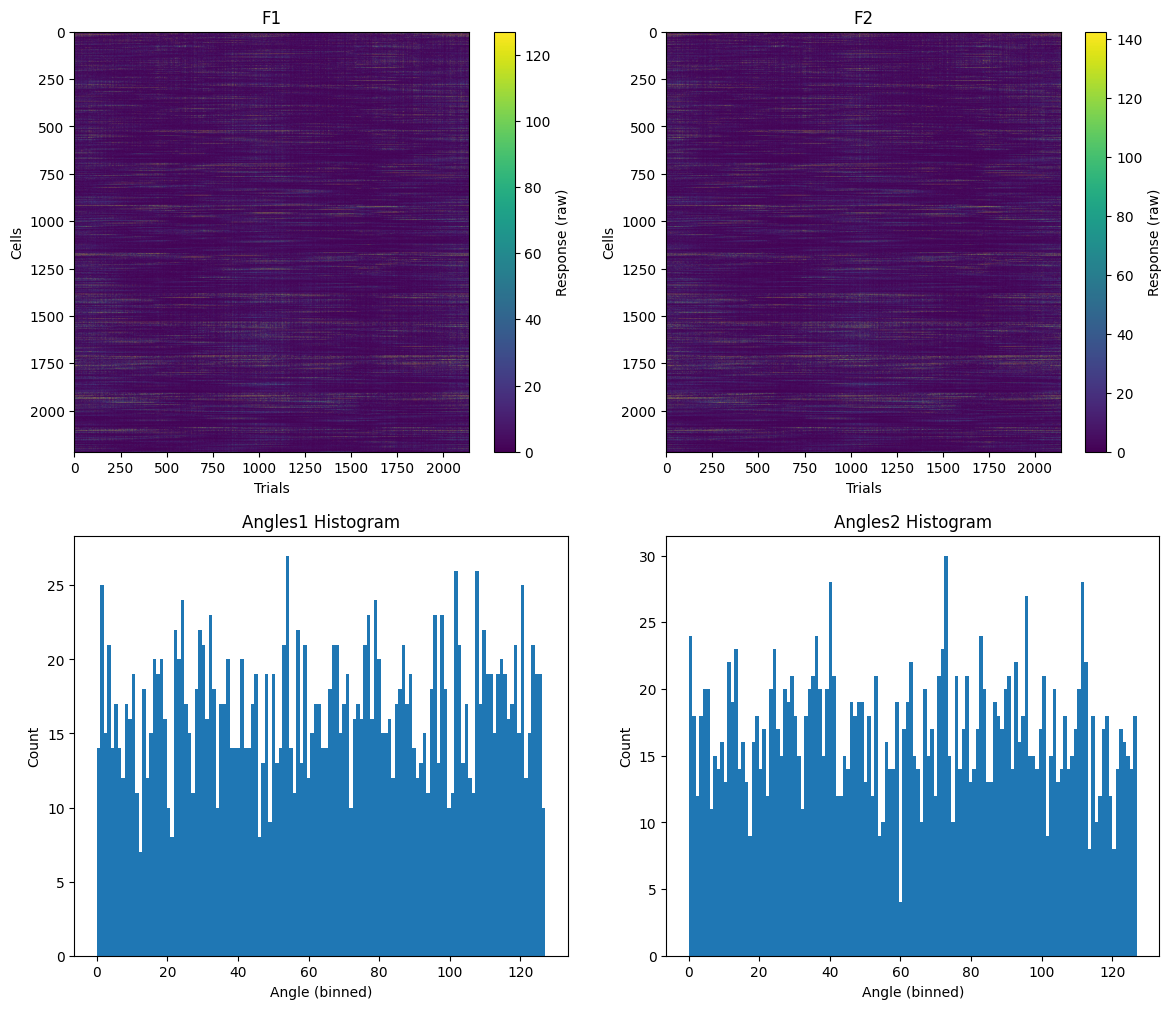

In [5]:
n_bins = 128
F1 = response[:, :n_trials // 2]
F2 = response[:, n_trials // 2:]
# collect angles in each half
angles1 = angles[:n_trials // 2]
angles2 = angles[n_trials // 2:]
# order each half by angle
order1 = jnp.argsort(angles1)
order2 = jnp.argsort(angles2)
F1 = F1[:, order1]
F2 = F2[:, order2]
# bin angles
angles1 = (n_bins * angles1[order1] / (2 * np.pi)).astype(int)
angles2 = (n_bins * angles2[order2] / (2 * np.pi)).astype(int)

plt.figure(figsize=(14, 12))
plt.subplot(221)
plt.imshow(F1, aspect='auto', vmin=np.percentile(F1, 1), vmax=np.percentile(F1, 99))
plt.title('F1')
plt.xlabel('Trials')
plt.ylabel('Cells')
plt.colorbar(label='Response (raw)')
plt.subplot(222)
plt.imshow(F2, aspect='auto', vmin=np.percentile(F2, 1), vmax=np.percentile(F2, 99))
plt.title('F2')
plt.xlabel('Trials')
plt.ylabel('Cells')
plt.colorbar(label='Response (raw)')
plt.subplot(223)
# plot histogram of angles1
plt.hist(angles1, bins=n_bins)
plt.title('Angles1 Histogram')
plt.xlabel('Angle (binned)')
plt.ylabel('Count')
plt.subplot(224)
# plot histogram of angles2
plt.hist(angles2, bins=n_bins)
plt.title('Angles2 Histogram')
plt.xlabel('Angle (binned)')
plt.ylabel('Count')
plt.show()

In [6]:
# --- inputs ------------------------------------------------------------
# angles1, angles2: length = n_trials   (integer bin labels 0 … n_bins-1)
# F1, F2: shape = (n_cells, n_trials)   (firing rates)
# -----------------------------------------------------------------------
angles  = [angles1, angles2]
F = [F1, F2]
R = [None, None] # will hold the two result arrays
n_cells, n_trials = F1.shape # assumes both sessions equal-sized

for s in range(2):
    ang = angles[s] # (n_trials,)
    Fs = F[s] # (n_cells, n_trials)

    # 1. One-hot matrix saying “trial t belongs to bin b”
    # shape: (n_bins, n_trials)
    bins = (ang == np.arange(n_bins)[:, None]).astype(np.float32)

    # 2. Mask out zero responses
    good_mask = (Fs > 0).astype(np.float32) # (n_cells, n_trials)

    # 3. Per-cell / per-bin sums and counts
    sums = Fs @ bins.T  # (n_cells, n_bins)
    counts = good_mask @ bins.T # (n_cells, n_bins) # counts of non-zero responses per cell per bin
    # count all responses per bin
    # counts = good_mask @ bins.T  # (n_cells, n_bins)

    # 4. Mean, guarding against “no–positive-spike” bins
    R[s] = np.divide(sums, counts, 
                     out=np.zeros_like(sums), 
                     where=counts > 0)  # (n_cells, n_bins)

# R[0] ≡ R1, R[1] ≡ R2
R1, R2 = R

# z score each cell 
R1 = (R1 - np.mean(R1, axis=1, keepdims=True)) / np.std(R1, axis=1, keepdims=True)
R2 = (R2 - np.mean(R2, axis=1, keepdims=True)) / np.std(R2, axis=1, keepdims=True)

In [7]:
# compute covariance matrices
cov1 = R1.T @ R1 / n_cells
cov2 = R2.T @ R2 / n_cells
cross_cov_sym = 0.5 * (R1.T @ R2 + R2.T @ R1) / n_cells

# compute eigenvalues
evals_cross, evecs_cross = np.linalg.eigh(cross_cov_sym)
sort_idx = np.argsort(evals_cross)[::-1]  # sort in descending order
evals_cross = evals_cross[sort_idx]
evecs_cross = evecs_cross[:, sort_idx]
evecs_cross = evecs_cross[:, evals_cross > 0]  # keep corresponding eigenvectors
evals_cross = evals_cross[evals_cross > 0]  # keep only positive eigenvalues
print(f'Number of positive eigenvalues in cross covariance: {len(evals_cross)}')

evals1 = np.linalg.eigvalsh(cov1)
evals1 = np.sort(evals1)[::-1]  # sort in descending order
evals1 = evals1[evals1 > 0]  # keep only positive eigenvalues
print(f'Number of positive eigenvalues in cov1: {len(evals1)}')

evals2 = np.linalg.eigvalsh(cov2)
evals2 = np.sort(evals2)[::-1]  # sort in descending order
evals2 = evals2[evals2 > 0]  # keep only positive eigenvalues
print(f'Number of positive eigenvalues in cov2: {len(evals2)}')

evals = [evals1, evals2, evals_cross]
eval_labels = ['cov1', 'cov2', 'cross_cov']
colors = ['blue', 'tab:green', 'tab:red']

Number of positive eigenvalues in cross covariance: 81
Number of positive eigenvalues in cov1: 127
Number of positive eigenvalues in cov2: 128


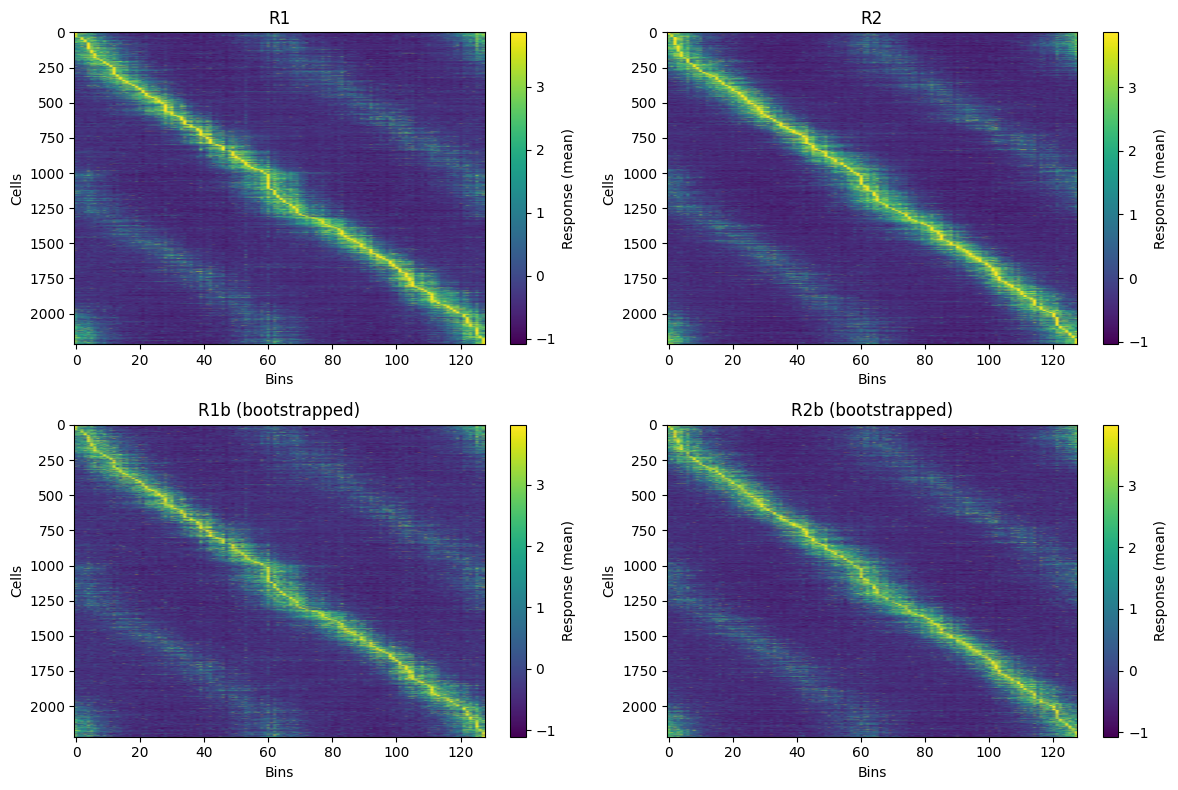

In [8]:
def binned_stats(F, ang, n_bins):
    """
    Returns per-cell-per-bin statistics of *positive* responses.

    F   : (n_cells, n_trials)
    ang : (n_trials,) int labels in 0 … n_bins-1
    """
    mask  = (F > 0).astype(np.float32)
    bins  = (ang == np.arange(n_bins)[:, None])      # (n_bins, n_trials)

    counts = mask @ bins.T                           # (n_cells, n_bins)
    sums   = (F * mask)       @ bins.T
    sqsum  = (F**2 * mask)    @ bins.T

    mu  = np.divide(sums, counts, out=np.zeros_like(sums), where=counts > 0)

    # unbiased variance   var = (Σx² − n μ²)/(n−1)
    var = np.zeros_like(sums)
    valid = counts > 1
    var[valid] = (sqsum[valid] - counts[valid] * mu[valid]**2) / (counts[valid]-1)

    # variance of the *sample mean*
    var_mean = np.divide(var, counts, out=np.zeros_like(var), where=counts > 0)

    return mu, var_mean, counts

def param_bootstrap_cross_eigs(F1, F2, a1, a2, n_bins,
                               n_iter=500, seed=0, descending=True):
    rng = np.random.default_rng(seed)
    N, _ = F1.shape

    # ----- pre-compute stats once ------------------------------------
    mu1, var1, _ = binned_stats(F1, a1, n_bins)
    mu2, var2, _ = binned_stats(F2, a2, n_bins)

    all_eigs = []

    for _ in range(n_iter):
        # random R* matrices -----------------------------------------
        sd1 = np.sqrt(np.clip(var1, 0, None))
        sd2 = np.sqrt(np.clip(var2, 0, None))
        R1b = rng.normal(mu1, sd1, size=mu1.shape)
        R2b = rng.normal(mu2, sd2, size=mu2.shape)

        # per-cell z-score (fresh each iteration, like your original)
        for R in (R1b, R2b):
            m = R.mean(axis=1, keepdims=True)
            s = R.std(axis=1, keepdims=True)
            s[s == 0] = 1.0
            R -= m
            R /= s

        Cb = 0.5*(R1b.T @ R2b + R2b.T @ R1b) / N
        eval_proj = np.diag(evecs_cross.T @ Cb @ evecs_cross)  # projection cross eigenvectors onto this matrix
        all_eigs.append(eval_proj)

    return np.array(all_eigs),R1b, R2b         # (n_iter, n_bins)

boot, R1b, R2b = param_bootstrap_cross_eigs(F1, F2, angles1, angles2, n_bins,
                                            n_iter=100, seed=321)
lo, hi = np.percentile(boot, [5.0, 100.0], axis=0)   # point-wise 95 % bands
lo = lo[:len(evals_cross)]
hi = hi[:len(evals_cross)]
lo = np.clip(lo, 1e-8, None)
hi = np.clip(hi, 1e-4, None)

plt.figure(figsize=(12, 8))
plt.subplot(221)
sort_idx1 = np.argsort(np.argmax(R1, axis=1))
plt.imshow(R1[sort_idx1, :], aspect='auto', vmin=np.percentile(R1, 1), vmax=np.percentile(R1, 99))
plt.title('R1')
plt.xlabel('Bins')
plt.ylabel('Cells')
plt.colorbar(label='Response (mean)')
plt.subplot(222)
sort_idx2 = np.argsort(np.argmax(R2, axis=1))
plt.imshow(R2[sort_idx2, :], aspect='auto', vmin=np.percentile(R2, 1), vmax=np.percentile(R2, 99))
plt.title('R2')
plt.xlabel('Bins')
plt.ylabel('Cells')
plt.colorbar(label='Response (mean)')
plt.subplot(223)
plt.imshow(R1b[sort_idx1, :], aspect='auto', vmin=np.percentile(R1b, 1), vmax=np.percentile(R1b, 99))
plt.title('R1b (bootstrapped)')
plt.xlabel('Bins')
plt.ylabel('Cells')
plt.colorbar(label='Response (mean)')
plt.subplot(224)
plt.imshow(R2b[sort_idx2, :], aspect='auto', vmin=np.percentile(R2b, 1), vmax=np.percentile(R2b, 99))
plt.title('R2b (bootstrapped)')
plt.xlabel('Bins')
plt.ylabel('Cells')
plt.colorbar(label='Response (mean)')
plt.tight_layout()
plt.show()

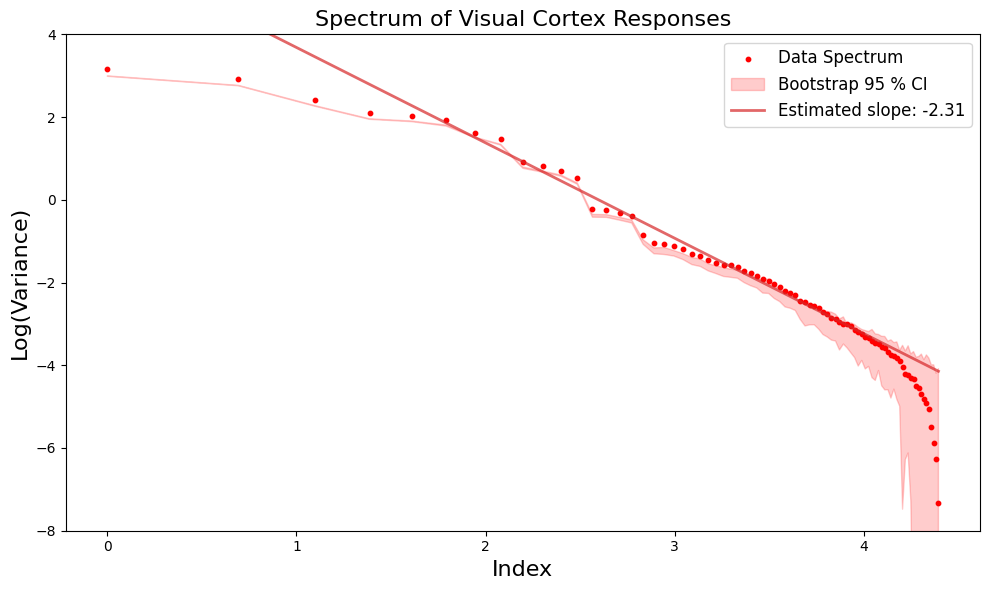

In [9]:
# --- your existing code up to here ------------------------------------
x_values = np.log(np.arange(1, len(evals_cross) + 1))
y_values = np.log(evals_cross)
start_idx, end_idx = 5, 45

# --- plot -------------------------------------------------------------
plt.figure(figsize=(10, 6))

# your red dots
plt.scatter(x_values, y_values, color='red', s=10, label='Data Spectrum')

# 95 % bootstrap band (unchanged)
plt.fill_between(x_values, np.log(lo), np.log(hi),
                 color='red', alpha=0.2, label='Bootstrap 95 % CI')

# # add vlines for the start and end indices
# plt.axvline(x=np.log(start_idx), color='black', linestyle='--', lw=1, label='Fit Range')
# plt.axvline(x=np.log(end_idx), color='black', linestyle='--', lw=1)

# (optional) your original unweighted line, comment out if not needed
slope_ols, int_ols = np.polyfit(x_values[start_idx:end_idx],
                                y_values[start_idx:end_idx], 1)
plt.plot(x_values, slope_ols * x_values + int_ols,
         color='tab:red', lw=2, alpha=0.7, label=f'Estimated slope: {slope_ols:.2f}')

# cosmetics
plt.ylim(-8, 4)
plt.xlabel('Index', fontsize=16); plt.ylabel('Log(Variance)', fontsize=16)
plt.title('Spectrum of Visual Cortex Responses', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

# Computing Model Spectrum

In [ ]:
# def neuron_model_numpy(theta,
#                     theta_pref_1=0.0,
#                     baseline=0.0,
#                     amplitude_1=1.0,
#                     width_ccw_1=1.0,
#                     width_cw_1=1.0,
#                     exponent_1=2.0,
#                     theta_pref_2=np.pi,
#                     amplitude_2=0.0,
#                     width_ccw_2=1.0,
#                     width_cw_2=1.0,
#                     exponent_2=2.0):
#     """"
#     parent_model_1: VariableExponent_AsymmetricBimodalModel
#     parent_model_2: IndependentLocation_AsymmetricPrimaryModel

#     Equation:
#     Helper Functions:
#     _signed_circ_diff_rad(angle, preferred_angle) = arctan2(sin(angle - preferred_angle), cos(angle - preferred_angle))

#     Component 1:
#     signed_diff_1 = _signed_circ_diff_rad(theta, theta_pref_1)
#     effective_width_1 = width_ccw_1 if signed_diff_1 < 0 else width_cw_1
#     component_1 = amplitude_1 * exp(-0.5 * (abs(signed_diff_1) / effective_width_1)**exponent_1)

#     Component 2:
#     signed_diff_2 = _signed_circ_diff_rad(theta, theta_pref_2)
#     effective_width_2 = width_ccw_2 if signed_diff_2 < 0 else width_cw_2
#     component_2 = amplitude_2 * exp(-0.5 * (abs(signed_diff_2) / effective_width_2)**exponent_2)

#     Response:
#     response = baseline + component_1 + component_2

#     This model creates a comprehensive bimodal tuning curve by intelligently combining and enhancing the most effective
#     features from its parent models, targeting specific shortcomings observed in the provided neural data.

#     Improvements:
#     1.  **Unified Peak Shape Flexibility and Asymmetry**: This model brings together the concept of variable exponents
#         (`exponent_1`, `exponent_2` from `parent_model_1`) and asymmetric tuning widths for both peaks (`width_ccw_1`, `width_cw_1`, `width_ccw_2`, `width_cw_2`,
#         inheriting from `parent_model_1`'s `tuning_width_pos/neg` for both peaks and `parent_model_2`'s `width_left/right` for the primary).
#         This provides unparalleled control over the ""peakedness"" (e.g., sharper than Gaussian for high exponents,
#         or fatter tails for low exponents to better fit broader shoulders as seen in Cell 91, 169) and the side-to-side
#         asymmetry of *both* the primary and secondary response profiles. `parent_model_2` lacked this crucial flexibility for both peaks.

#     2.  **Fully Independent Secondary Peak Placement**: Crucially, this model retains `parent_model_2`'s enhancement of allowing the secondary
#         preferred direction (`theta_pref_2`) to be fully independent. Unlike `parent_model_1`, which constrained the
#         secondary peak to be an offset from the primary's antipodal angle, `theta_pref_2` can be optimized freely. This is vital
#         for capturing neurons with complex bimodal tuning where the secondary peak is not strictly 180 degrees from the primary
#         (as observed in cells like Cell 1 and Cell 222 in previous models' descriptions, implying non-antipodal secondary peaks).

#     3.  **Enhanced Fit Accuracy:** By integrating these powerful and complementary features, this model is designed to
#         overcome systematic weaknesses of its predecessors. It provides a more robust framework to capture
#         the detailed nuances of neuronal responses, from highly skewed and sharp primary peaks to broad and
#         asymmetrically shaped secondary responses that can appear at any angle, thereby leading to a
#         significantly lower overall loss.
#     """
#     # Helper function for signed circular difference, essential for asymmetric tuning
#     # Result is in range (-pi, pi]
#     def _signed_circ_diff_rad(angle_radians, preferred_angle_radians):
#         delta = angle_radians - preferred_angle_radians
#         return np.arctan2(np.sin(delta), np.cos(delta))

#     # --- Peak 1: Asymmetric, Variable Exponent Gaussian component ---
#     signed_diff_1 = _signed_circ_diff_rad(theta, theta_pref_1)

#     # Select width based on the sign of the circular difference (counter-clockwise vs. clockwise)
#     width_1_effective = np.where(signed_diff_1 < 0, width_ccw_1, width_cw_1)
    
#     # Ensure widths are positive to prevent numerical instability (e.g., division by zero or log of non-positive)
#     width_1_effective = np.maximum(width_1_effective, 1e-6) 

#     # Calculate the first peak's contribution with variable exponent
#     # abs(signed_diff_1) is used because the exponent should operate on the magnitude of the difference.
#     peak1_component = amplitude_1 * np.exp(-0.5 * (np.abs(signed_diff_1) / width_1_effective) ** exponent_1)

#     # --- Peak 2: Asymmetric, Variable Exponent Gaussian component with independent preferred angle ---
#     signed_diff_2 = _signed_circ_diff_rad(theta, theta_pref_2)

#     # Select width based on the sign of the circular difference for the second peak
#     width_2_effective = np.where(signed_diff_2 < 0, width_ccw_2, width_cw_2)

#     # Ensure widths are positive
#     width_2_effective = np.maximum(width_2_effective, 1e-6)

#     # Calculate the second peak's contribution with variable exponent
#     peak2_component = amplitude_2 * np.exp(-0.5 * (np.abs(signed_diff_2) / width_2_effective) ** exponent_2)

#     # Total model response
#     return baseline + peak1_component + peak2_component

# def neuron_model(theta,
#                 theta_pref_1=0.0,
#                 baseline=0.0,
#                 amplitude_1=1.0,
#                 width_ccw_1=1.0,
#                 width_cw_1=1.0,
#                 exponent_1=2.0,
#                 theta_pref_2=jnp.pi,
#                 amplitude_2=0.0,
#                 width_ccw_2=1.0,
#                 width_cw_2=1.0,
#                 exponent_2=2.0):
    
#     width_ccw_1, width_cw_1 = jnp.clip(width_ccw_1, 1e-6, None), jnp.clip(width_cw_1, 1e-6, None)
#     width_ccw_2, width_cw_2 = jnp.clip(width_ccw_2, 1e-6, None), jnp.clip(width_cw_2, 1e-6, None)
#     exponent_1, exponent_2 = jnp.clip(exponent_1, 0.1, 5.0), jnp.clip(exponent_2, 0.1, 5.0)
    
#     def _signed_circ_diff_rad(angle_radians, preferred_angle_radians):
#         delta = angle_radians - preferred_angle_radians
#         return jnp.arctan2(jnp.sin(delta), jnp.cos(delta))

#     eps = 1e-12
#     signed_diff_1 = _signed_circ_diff_rad(theta, theta_pref_1) + eps  # Add small epsilon to avoid log(0) issues
#     width_1_effective = jnp.where(signed_diff_1 < 0, width_ccw_1, width_cw_1)
#     width_1_effective = jnp.maximum(width_1_effective, 1e-6)
#     peak1_component = amplitude_1 * jnp.exp(-0.5 * (jnp.abs(signed_diff_1) / width_1_effective) ** exponent_1)

#     signed_diff_2 = _signed_circ_diff_rad(theta, theta_pref_2) + eps  # Add small epsilon to avoid log(0) issues
#     width_2_effective = jnp.where(signed_diff_2 < 0, width_ccw_2, width_cw_2)
#     width_2_effective = jnp.maximum(width_2_effective, 1e-6)
#     peak2_component = amplitude_2 * jnp.exp(-0.5 * (jnp.abs(signed_diff_2) / width_2_effective) ** exponent_2)

#     return baseline + peak1_component + peak2_component

# def parameter_estimator(stimuli, spike_counts):
#     """
#     Estimates parameters for the neuron_model_v3 based on stimulus angles and observed spike counts.
#     This estimator employs statistical principles to identify and characterize tuning curve peaks,
#     including baseline, amplitude, asymmetric widths, preferred directions, and exponents for
#     two potential peaks.

#     Parameters are estimated directly from a smoothed firing rate curve, aiming for a simple
#     yet robust initial estimation suitable for generalized Gaussian-like tuning profiles.

#     Parameters:
#     stimuli (np.ndarray): An array of stimulus angles in radians (0 to 2*pi).
#     spike_counts (np.ndarray): An array of spike counts corresponding to each stimulus.

#     Returns:
#     np.ndarray: An array containing the estimated parameters in the following order:
#                 [theta_pref_1, baseline, amplitude_1, width_ccw_1, width_cw_1,
#                  exponent_1, theta_pref_2, amplitude_2, width_ccw_2, width_cw_2, exponent_2]
#     """
#     # --- Configuration Constants ---
#     n_bins = 180  # Number of angular bins for tuning curve estimation
#     kernel_sigma = 2.5 # Sigma for Gaussian smoothing kernel
#     min_peak_amplitude = 0.5 # Min amplitude (spikes/stimulus) above baseline for a peak to be considered valid
#     min_model_width = 1e-6 # Minimum allowed width for numerical stability (as per model)
#     default_width_value = 1.0 # Default width for non-significant peaks or non-determinable widths
#     min_exponent = 0.1 # Minimum allowed exponent value
#     max_exponent = 5.0 # Maximum allowed exponent value
#     default_exponent_value = 2.0 # Default exponent (Gaussian)
#     min_second_peak_ratio = 0.1 # Min amplitude of secondary peak relative to primary
#     min_second_peak_separation = np.pi / 4 # Min angular separation between primary and secondary peaks

#     # --- 1. Binning and Smoothing ---
#     # Convert stimuli to bin indices, handle wrap-around implicitly by modulo in bincount
#     bin_idx = ((stimuli * n_bins) / (2 * np.pi)).astype(np.int32)
#     bin_idx = np.clip(bin_idx, 0, n_bins - 1)

#     sums = np.bincount(bin_idx, weights=spike_counts, minlength=n_bins)
#     counts = np.bincount(bin_idx, minlength=n_bins)

#     # Create Gaussian smoothing kernel
#     kernel_radius = int(3 * kernel_sigma)
#     x_kernel = np.arange(-kernel_radius, kernel_radius + 1)
#     kernel = np.exp(-0.5 * (x_kernel / kernel_sigma) ** 2)
#     kernel /= (np.sum(kernel) + 1e-8) # Normalize kernel

#     # Pad arrays for circular convolution
#     pad = len(kernel) // 2
#     sums_padded = np.pad(sums, (pad, pad), mode='wrap')
#     counts_padded = np.pad(counts, (pad, pad), mode='wrap')

#     # Convolve to get smoothed sum of spikes and counts
#     num_conv = np.convolve(sums_padded, kernel, mode='valid')
#     den_conv = np.convolve(counts_padded, kernel, mode='valid')

#     # Calculate smoothed tuning curve (avoid division by zero)
#     tuning_curve = np.zeros_like(num_conv, dtype=float)
#     valid_den_mask = den_conv > 1e-8
#     tuning_curve[valid_den_mask] = num_conv[valid_den_mask] / den_conv[valid_den_mask]

#     angle_step = 2 * np.pi / n_bins

#     # --- 2. Baseline Estimation ---
#     # Baseline cannot be negative
#     baseline_est = np.maximum(0.0, np.min(tuning_curve))

#     # --- Helper function for estimating peak shape parameters ---
#     def _get_peak_params_simple(peak_idx_val, peak_idx, bsl, tc, n_bns, ang_step,
#                                 min_w, def_w, min_exp, max_exp, def_exp, min_amp_thresh):
#         amp = peak_idx_val - bsl
#         if amp < min_amp_thresh:
#             return amp, def_w, def_w, def_exp # Return default parameters if amplitude too small

#         # Find bins where tuning curve drops below half-max
#         target_half_val = bsl + amp / 2.0
#         half_ccw_bins, half_cw_bins = 0, 0
#         for k in range(1, n_bns // 2 + 1):
#             if half_ccw_bins == 0 and tc[(peak_idx - k + n_bns) % n_bns] <= target_half_val:
#                 half_ccw_bins = k
#             if half_cw_bins == 0 and tc[(peak_idx + k) % n_bns] <= target_half_val:
#                 half_cw_bins = k
#             if half_ccw_bins > 0 and half_cw_bins > 0:
#                 break
        
#         # Calculate width (v1-style, implicitly assuming Gaussian form for width parameter base)
#         SQRT_2_LOG_2 = np.sqrt(2 * np.log(2)) 
#         width_ccw = (half_ccw_bins * ang_step) / SQRT_2_LOG_2 if half_ccw_bins > 0 else def_w
#         width_cw = (half_cw_bins * ang_step) / SQRT_2_LOG_2 if half_cw_bins > 0 else def_w
        
#         # Clip widths to valid range
#         width_ccw = np.clip(width_ccw, min_w, np.pi)
#         width_cw = np.clip(width_cw, min_w, np.pi)

#         # Find bins where tuning curve drops below quarter-max for exponent estimation
#         target_qtr_val = bsl + amp / 4.0
#         qtr_ccw_bins, qtr_cw_bins = 0, 0
#         for k in range(1, n_bns // 2 + 1):
#             if qtr_ccw_bins == 0 and tc[(peak_idx - k + n_bns) % n_bns] <= target_qtr_val:
#                 qtr_ccw_bins = k
#             if qtr_cw_bins == 0 and tc[(peak_idx + k) % n_bns] <= target_qtr_val:
#                 qtr_cw_bins = k
#             if qtr_ccw_bins > 0 and qtr_cw_bins > 0:
#                 break
        
#         # Exponent estimation (log(2) / log(dist_qtr / dist_half))
#         exponent_estimates = []
#         if half_ccw_bins > 0 and qtr_ccw_bins > half_ccw_bins: # Ensure ratio > 1 for valid log
#             exponent_estimates.append(np.log(2) / np.log(qtr_ccw_bins / half_ccw_bins))
#         if half_cw_bins > 0 and qtr_cw_bins > half_cw_bins:
#             exponent_estimates.append(np.log(2) / np.log(qtr_cw_bins / half_cw_bins))
        
#         # Take mean of valid estimates, else default
#         exponent = np.mean(exponent_estimates) if exponent_estimates else def_exp
#         exponent = np.clip(exponent, min_exp, max_exp)
        
#         return amp, width_ccw, width_cw, exponent

#     # --- 3. Peak Identification and Parameter Estimation ---
#     # Find all local maxima in the smoothed tuning curve
#     local_maxima = []
#     for i in range(n_bins):
#         prev_val = tuning_curve[(i - 1 + n_bins) % n_bins]
#         next_val = tuning_curve[(i + 1) % n_bins]
#         if tuning_curve[i] >= prev_val and tuning_curve[i] >= next_val:
#             local_maxima.append((tuning_curve[i], i))
#     local_maxima.sort(key=lambda x: x[0], reverse=True) # Sort by peak amplitude (descending)

#     # Initialize all output parameters with model defaults (if no peak is found)
#     theta_pref_1 = 0.0
#     amplitude_1 = default_width_value # amplitude for primary peak default to 1 for non-zero contribution if peak is small
#     width_ccw_1, width_cw_1, exponent_1 = default_width_value, default_width_value, default_exponent_value
    
#     theta_pref_2 = np.pi # Antipodal to default theta_pref_1
#     amplitude_2 = 0.0 # Default no second peak
#     width_ccw_2, width_cw_2, exponent_2 = default_width_value, default_width_value, default_exponent_value

#     # Process Primary Peak
#     if local_maxima:
#         peak_1_val, peak_1_idx = local_maxima[0]
#         # Estimate parameters for the primary (highest) peak
#         amplitude_1, width_ccw_1, width_cw_1, exponent_1 = \
#             _get_peak_params_simple(peak_1_val, peak_1_idx, baseline_est, tuning_curve, n_bins, angle_step,
#                                     min_model_width, default_width_value, min_exponent, max_exponent,
#                                     default_exponent_value, min_peak_amplitude)
#         theta_pref_1 = peak_1_idx * angle_step
        
#         # Process Secondary Peak (if a suitable candidate exists)
#         if len(local_maxima) > 1:
#             # Iterate through other local maxima to find a suitable secondary peak
#             for i in range(1, len(local_maxima)):
#                 peak_2_val_candidate, peak_2_idx_candidate = local_maxima[i]
#                 current_amplitude_2_candidate = peak_2_val_candidate - baseline_est
#                 current_theta_pref_2_candidate = peak_2_idx_candidate * angle_step
                
#                 # Check amplitude significance relative to primary peak's estimated amplitude
#                 if current_amplitude_2_candidate < (amplitude_1 * min_second_peak_ratio):
#                     continue # Skip if too small compared to the primary peak
                
#                 # Check angular separation from the *primary* peak
#                 # np.arctan2(sin(a-b), cos(a-b)) gives circular distance in [-pi, pi]
#                 peak_sep_rad = np.abs(np.arctan2(np.sin(theta_pref_1 - current_theta_pref_2_candidate),
#                                                  np.cos(theta_pref_1 - current_theta_pref_2_candidate)))
#                 if peak_sep_rad < min_second_peak_separation:
#                     continue # Skip if too close to the primary peak

#                 # Valid secondary peak found, estimate its parameters
#                 amplitude_2, width_ccw_2, width_cw_2, exponent_2 = \
#                     _get_peak_params_simple(peak_2_val_candidate, peak_2_idx_candidate, baseline_est, tuning_curve, n_bins, angle_step,
#                                             min_model_width, default_width_value, min_exponent, max_exponent,
#                                             default_exponent_value, min_peak_amplitude)
#                 theta_pref_2 = current_theta_pref_2_candidate
                
#                 # Break after finding the first suitable secondary peak (highest amplitude among remaining candidates)
#                 break
    
#     # --- Pack and return parameters in the correct order for neuron_model_v3 ---
#     return np.array([theta_pref_1, baseline_est, amplitude_1, width_ccw_1, width_cw_1,
#                      0.5, theta_pref_2, amplitude_2, width_ccw_2, width_cw_2, 0.5])

# param_names = ['theta_pref_1', 'baseline', 'amplitude_1', 'width_ccw_1', 'width_cw_1',
#                'exponent_1', 'theta_pref_2', 'amplitude_2', 'width_ccw_2', 'width_cw_2',
#                'exponent_2']

In [10]:
neuron_model = seed_programs.neuron_model_2_jax
parameter_estimator = seed_programs.parameter_estimator_2

In [11]:
# To train the model, we only extract the reliable responses ( > 0).
# We can overwrite response and angles with the cropped versions, as we already have R1 and R2
conc_thresh, activity_thresh = 0.45, 0.45 # thresholds for conc and activity
data_dir = '/home/reilly/Downloads/8279387/gratings_drifting_GT1_2019_04_12_1.npy'
# data_dir = '/Users/reillytilbury/Desktop/gratings/gratings_static_GT1_2019_04_17_1.npy'
neural_data = np.load(data_dir, allow_pickle=True)
neural_data = neural_data.item()
response = utils.extract_stimulus_related_response(neural_data, n_pcs=0)
angles = neural_data['istim']
n_trials = response.shape[1]
n_trials_small = int(n_trials * activity_thresh)

# filter 
active = (response > 0).astype(np.float32)
firing_probs = np.mean(active, axis=1)
conc = np.abs(np.sum(np.exp(2j * angles)[np.newaxis, :] * response, axis=1) / np.sum(response, axis=1))
good_cells = np.where((firing_probs > activity_thresh) & (conc > conc_thresh))[0]
n_good_cells = len(good_cells)
conc = conc[good_cells]
firing_probs = firing_probs[good_cells]

# update angles and response to be (n_cells_small, n_trials_small) and (n_cells_small, n_trials_small)
response_cropped, angles_cropped = np.zeros((len(good_cells), n_trials_small)), np.zeros((len(good_cells), n_trials_small))
for i, cell in enumerate(good_cells):
    active_trials = response[cell] > 0
    active_trials_idx = np.where(active_trials)[0][:n_trials_small]
    response_cropped[i] = response[cell, active_trials_idx]
    angles_cropped[i] = angles[active_trials_idx]
    
# update response and angles to be the cropped versions and convert to JAX arrays
response, angles = jnp.asarray(response_cropped), jnp.asarray(angles_cropped)
# normalize response of each cell
response_norms = jnp.linalg.norm(response, axis=1)
response = 100 * response / response_norms[:, None]  # scale to 100
del neural_data

In [12]:
params_init = hypothesis_engine.compute_initial_params(
    param_estimator=parameter_estimator,
    neuron_model=neuron_model,
    x=np.asarray(angles),
    y=np.asarray(response)
)
n_cells, n_params = params_init.shape
loss_single_cell = lambda params, x_data, y_data: jnp.mean(loss_functions.quadratic_loss(neuron_model(x_data, *params), y_data), axis=-1)
# vectorize the loss function for all cells. The inputs will have shapes:
# - params: (n_cells, n_params)
# - x_data: (n_cells, n_trials)
# - y_data: (n_cells, n_trials)
loss_total = jax.vmap(loss_single_cell, in_axes=(0, 0, 0), out_axes=0)
loss_param = lambda params_flat: jnp.mean(loss_total(params_flat.reshape(n_cells, n_params), angles, response))
loss_param = jax.jit(loss_param)  # JIT compile the loss function for performance
loss_param_and_grad = jax.value_and_grad(loss_param)

In [13]:
# ------------------------------------------------------------------
# 2.  build the Adam optimiser -------------------------------------
learning_rate = 3e-3       # good default; tune if needed
beta1, beta2  = 0.9, 0.999    # the usual Adam constants

opt = optax.adam(learning_rate, b1=beta1, b2=beta2, eps=1e-8)
opt_state = opt.init(params_init.reshape(-1))  # Flatten params for the optimizer

@jax.jit
def train_step(params, opt_state):
    loss, grad = loss_param_and_grad(params)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# ------------------------------------------------------------------
# 3.  iterate -------------------------------------------------------
num_steps =  6000            # or stop on validation patience
print_every = 100

params = params_init.reshape(-1)  # Flatten params for the optimizer
best_params = params.copy()  # Keep track of the best parameters
best_loss = float('inf')  # Initialize best loss to infinity
for step in range(1, num_steps + 1):
    params, opt_state, loss_val = train_step(params, opt_state)
    if step % print_every == 0:
        print(f"step {step:4d}  loss {loss_val:.4f}")
    if loss_val < best_loss:
        best_loss = loss_val
        best_params = params.copy()

# Reshape best_params back to (n_cells, n_params) for further analysis
params = best_params.reshape(n_cells, n_params)
# param_names = [
#     'theta_pref_1', 'baseline', 'amplitude_1', 'amplitude_2', 'width']

step  100  loss 26.8066
step  200  loss 26.6422
step  300  loss 26.5585
step  400  loss 26.5118
step  500  loss 26.4845
step  600  loss 26.4673
step  700  loss 26.4570
step  800  loss 26.4506
step  900  loss 26.4465
step 1000  loss 26.4438
step 1100  loss 26.4419
step 1200  loss 26.4406
step 1300  loss 26.4397
step 1400  loss 26.4390
step 1500  loss 26.4385
step 1600  loss 26.4382
step 1700  loss 26.4379
step 1800  loss 26.4377
step 1900  loss 26.4375
step 2000  loss 26.4374
step 2100  loss 26.4373
step 2200  loss 26.4373
step 2300  loss 26.4372
step 2400  loss 26.4372
step 2500  loss 26.4371
step 2600  loss 26.4371
step 2700  loss 26.4371
step 2800  loss 26.4371
step 2900  loss 26.4371
step 3000  loss 26.4371
step 3100  loss 26.4371
step 3200  loss 26.4371
step 3300  loss 26.4371
step 3400  loss 26.4371
step 3500  loss 26.4371
step 3600  loss 26.4371
step 3700  loss 26.4371
step 3800  loss 26.4371
step 3900  loss 26.4371
step 4000  loss 26.4371
step 4100  loss 26.4371
step 4200  loss 

In [14]:
angle_linspace = jnp.linspace(0, 2 * np.pi, n_bins, endpoint=False)
predictions = np.array([neuron_model(angle_linspace, *params[i]) for i in range(n_cells)])

/tmp/ipykernel_1807189/2662400443.py:11: RuntimeWarning: invalid value encountered in log
  y_values = np.log(evals_cross)
/tmp/ipykernel_1807189/2662400443.py:30: RuntimeWarning: invalid value encountered in log
  y_values = np.log(evals_p)


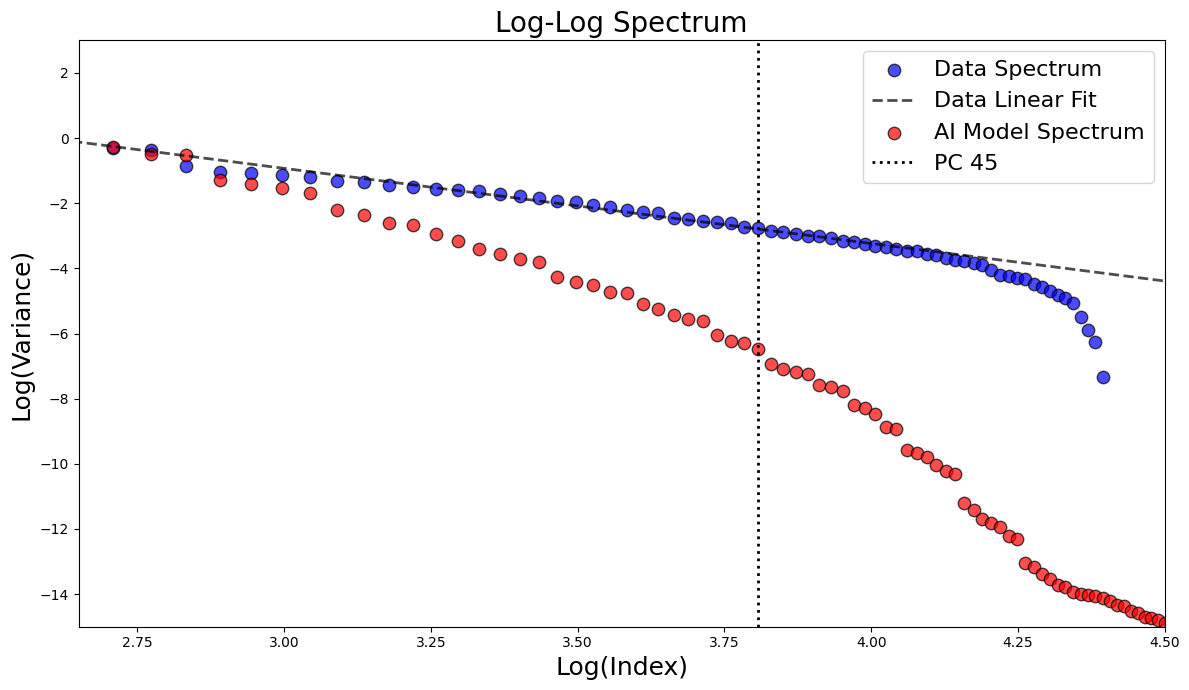

In [15]:
# plot true eigenvalues on training cells
cross_cov_sym = (R1.T @ R2 + R2.T @ R1) / (2 * R1.shape[0])
evals_cross, evecs_cross = np.linalg.eigh(cross_cov_sym)
evals_cross = evals_cross[::-1]  # reverse order to have largest eigenvalue
evecs_cross = evecs_cross[:, ::-1]  # reverse order to match eigenvalues

start_idx, end_idx = 5, 75
# plot the log eigenvalues of the cross covariance
x_values = np.log(np.arange(1, len(evals_cross) + 1))
# x_values = np.arange(1, len(evals_cross) + 1)
y_values = np.log(evals_cross)

plt.figure(figsize=(12, 7))
plt.scatter(x_values, y_values, color='blue', s=80, label='Data Spectrum', edgecolors='black', alpha=0.7)
plt.plot(x_values, slope_ols * x_values + int_ols,
         color='k', lw=2, linestyle='--', alpha=0.7, label='Data Linear Fit')
# fit a line to the log eigenvalues of the data
slope_ols, int_ols = np.polyfit(x_values[start_idx:end_idx], y_values[start_idx:end_idx], 1)

# compute the covariance matrix of the predictions
cov_p = predictions.T @ predictions / predictions.shape[0]  # covariance matrix of the z-scored predictions
evals_p, evecs_p = np.linalg.eigh(cov_p)  # sort eigenvalues and eigenvectors
evals_p = evals_p[::-1]  # reverse order to have largest eigenvalue first
evecs_p = evecs_p[:, ::-1]  # reverse order to match eigenvalues

# plot the log eigenvalues of the predictions
# plt.figure(figsize=(8, 6))
x_values = np.log(np.arange(1, len(evals_p) + 1))
# x_values = np.arange(1, len(evals_p) + 1)
y_values = np.log(evals_p)
plt.scatter(x_values, y_values, color='red', s=80, label='AI Model Spectrum', edgecolors='black', alpha=0.7)

# fit a line to the log eigenvalues
# slope_p, int_p = np.polyfit(x_values[start_idx:end_idx], y_values[start_idx:end_idx], 1)
# plt.plot(x_values, slope_p * x_values + int_p,
#          color='tab:blue', lw=2, linestyle='--', alpha=0.7, label=f'Slope: {slope_p:.2f}')

# add y line at log(
# plt.ylim(-15, 10)
# plt.xlim(-0.25, 4.5)
plt.ylim(-15, 3)
plt.xlim(2.65, 4.5)
# make x and y ticks larger
# plot a vertical line at x=40
plt.axvline(x=np.log(45), color='black', linestyle=':', lw=2, label='PC 45')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Log(Index)', fontsize=18); plt.ylabel('Log(Variance)', fontsize=18)
plt.title('Log-Log Spectrum', fontsize=20)
plt.legend(fontsize=16, loc='upper right')
plt.tight_layout()
plt.show()

In [16]:
R1_z = (R1 - np.mean(R1, axis=1, keepdims=True)) / np.std(R1, axis=1, keepdims=True)
R2_z = (R2 - np.mean(R2, axis=1, keepdims=True)) / np.std(R2, axis=1, keepdims=True)
R_mean = (R1_z + R2_z) / 2  # mean of the z-scored responses
R_z = (R_mean - np.mean(R_mean, axis=1, keepdims=True)) / np.std(R_mean, axis=1, keepdims=True)
U_pred, _, _ = np.linalg.svd(predictions, full_matrices=False)  # singular value decomposition of the z-scored response
U_data, _, _ = np.linalg.svd(R_z, full_matrices=False)  # singular value decomposition of the z-scored response

In [ ]:
from tqdm import tqdm
from statsmodels.nonparametric.smoothers_lowess import lowess

# compute lowess mean for all cells
evaluation_points = np.linspace(0, 2 * np.pi, n_bins, endpoint=False)
lowess_means = np.zeros((response.shape[0], n_bins))
# loop over cells
for i in tqdm(range(response.shape[0])):
    x = angles[i].copy()
    y = response[i].copy()
    n_responses = len(x)
    # extend the angles and responses to handle circular nature
    x = np.concatenate([x - 2 * np.pi, x, x + 2 * np.pi])
    y = np.concatenate([y, y, y])
    # Use LOWESS to smooth the response
    mean_est = lowess(y, x, frac=0.06 / 3, it=0, delta=0.0, return_sorted=True)
    angle_sorted = mean_est[:,0]
    resp_smoothed = mean_est[:,1]
    lowess_means[i] = np.interp(evaluation_points, angle_sorted, resp_smoothed)

100%|██████████| 2218/2218 [03:24<00:00, 10.85it/s]


In [36]:
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# cell_idx = np.random.choice(response.shape[0])  # randomly select a cell to plot
# plt.plot(angle_linspace, lowess_means[cell_idx], label='Matern GP', color='tab:orange')
# plt.plot(angle_linspace, predictions[cell_idx], label='Double Gaussian', color='tab:blue')
# plt.xlabel(r"$\theta$ (degrees)")
# # plt.xticks(np.linspace(0, n_bins, 8, endpoint=False),
# #            [f'{i * 45}°' for i in range(8)])
# plt.ylabel('Response (mean)')
# plt.title('Matern GP vs Double Gaussian')
# plt.legend()
# plt.subplot(122)
# plt.imshow(lowess_means, aspect='auto', vmin=np.percentile(lowess_means, 1), vmax=np.percentile(lowess_means, 99))
# plt.title('Matern GP Predictions')
# plt.xlabel('Bins')
# plt.ylabel('Cells')
# plt.colorbar(label='Response (mean)')
# plt.tight_layout()
# plt.show()
# # ────────────────────────────────────────────────────────────────────────────────

In [18]:
# z score the predictions and lowess means
predictions = (predictions - np.mean(predictions, axis=1, keepdims=True)) / np.std(predictions, axis=1, keepdims=True)
lowess_means = (lowess_means - np.mean(lowess_means, axis=1, keepdims=True)) / np.std(lowess_means, axis=1, keepdims=True)
# compute svd
U_data, _, _ = np.linalg.svd(R_z, full_matrices=False)  # singular value decomposition of the z-scored response
U_pred, _, _ = np.linalg.svd(predictions, full_matrices=False)  # singular value decomposition of the z-scored response
U_lowess, _, _ = np.linalg.svd(lowess_means, full_matrices=False)  # singular value decomposition of the z-scored response

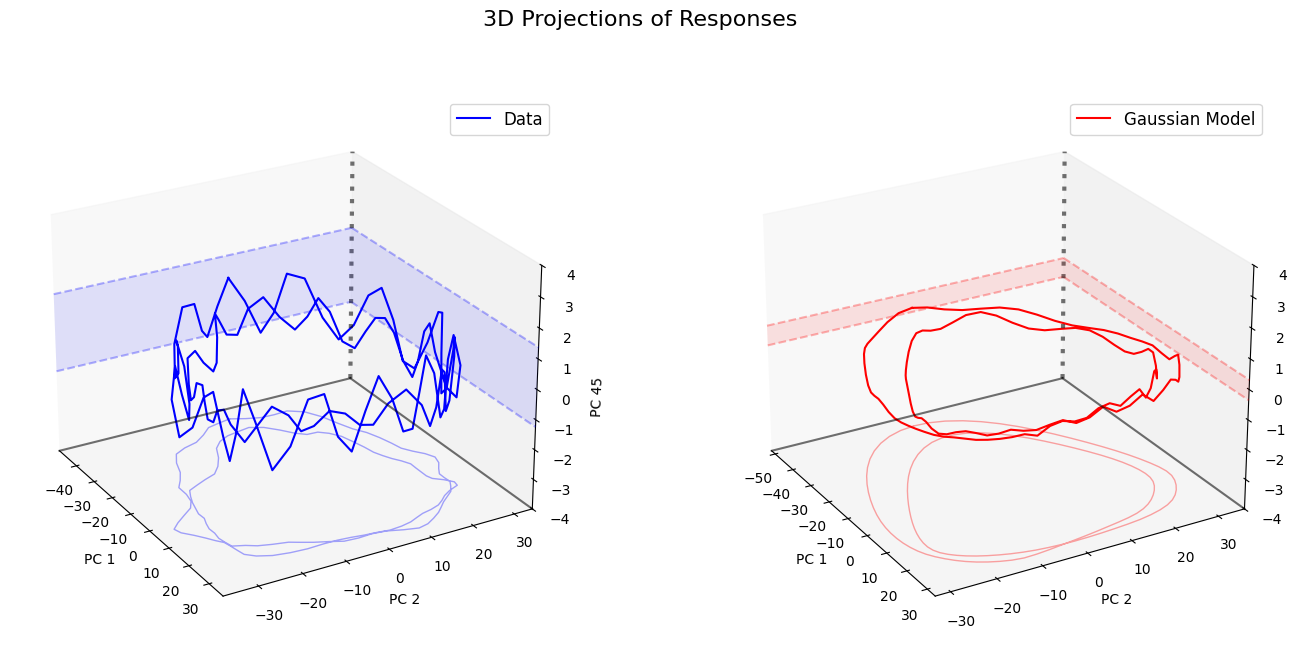

In [22]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage import gaussian_filter1d

# ------------------------------------------------------------------
# 1.  Compute projections  -----------------------------------------
# ------------------------------------------------------------------
projection_matrix_pred = U_pred[:, [0, 1, 50]]
projection_matrix_lowess = U_lowess[:, [0, 1, 50]]
projection_matrix_data = U_data[:, [0, 1, 50]]

# proj_true = R_z.T @ projection_matrix_data
proj_true = lowess_means.T @ projection_matrix_lowess
proj_pred = predictions.T @ projection_matrix_pred

# smooth a little and then close the loop
# proj_true[:, 2] = gaussian_filter1d(proj_true[:, 2], sigma=.5)
# proj_pred[:, 2] = gaussian_filter1d(proj_pred[:, 2], sigma=.5)
proj_true = np.vstack((proj_true, proj_true[0]))
proj_pred = np.vstack((proj_pred, proj_pred[0]))

# ------------------------------------------------------------------
# 2.  Helper functions  -------------------------------------------
# ------------------------------------------------------------------
def add_z_band_on_walls(ax, zmin, zmax, color, alpha=0.1, ls='--'):
    """Shade z-extent on the back walls (xz, yz) plus dashed edges."""
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    walls = [
        # yz wall @ x = xmin
        [(xmin, ymin, zmin), (xmin, ymin, zmax),
         (xmin, ymax, zmax), (xmin, ymax, zmin)],
        # xz wall @ y = ymax
        [(xmin, ymax, zmin), (xmax, ymax, zmin),
         (xmax, ymax, zmax), (xmin, ymax, zmax)]
    ]
    ax.add_collection3d(
        Poly3DCollection(walls, facecolors=color, alpha=alpha, linewidths=0)
    )

    # dashed outlines (top & bottom of each wall)
    ax.plot([xmin, xmin], [ymin, ymax], [zmin, zmin],
            color=color, linestyle=ls, alpha=3*alpha)
    ax.plot([xmin, xmin], [ymin, ymax], [zmax, zmax],
            color=color, linestyle=ls, alpha=3*alpha)
    ax.plot([xmin, xmax], [ymax, ymax], [zmin, zmin],
            color=color, linestyle=ls, alpha=3*alpha)
    ax.plot([xmin, xmax], [ymax, ymax], [zmax, zmax],
            color=color, linestyle=ls, alpha=3*alpha)

def draw_axes_cross(ax, axis_alpha=0.6):
    """Black axes that meet at (xmin, ymax, zmin)."""
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    zmin, zmax = ax.get_zlim()

    x0, y0, z0 = xmin, ymax, zmin
    # plot z with loosely dotted lines, parametrized by d
    d = 2
    ax.plot([x0, x0], [y0, y0], [zmin, zmax], color='k', alpha=axis_alpha, lw=3, linestyle=(0, (1, d)))
    ax.plot([xmin, xmax], [y0, y0], [z0, z0],   color='k', alpha=axis_alpha, lw=1.5)
    ax.plot([x0, x0], [ymin, ymax], [z0, z0],   color='k', alpha=axis_alpha, lw=1.5)

def style_axis(ax, zlabel='PC 45'):
    ax.grid(False)
    ax.set_xlabel('PC 1', labelpad=4)
    ax.set_ylabel('PC 2', labelpad=4)
    ax.set_zlabel(zlabel, labelpad=4)
    ax.set_zlim(-4, 4)
    ax.view_init(elev=25, azim=-30)

# ------------------------------------------------------------------
# 3.  Plotting  ----------------------------------------------------
# ------------------------------------------------------------------
fig = plt.figure(figsize=(14,8))
band_alpha, axis_alpha = 0.10, 0.55

# --------- FIRST PANEL (data) ------------------------------------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(*proj_true.T, color='blue', label='Data')
ax1.plot(proj_true[:, 0], proj_true[:, 1], -4 * np.ones_like(proj_true[:, 0]),
         color='blue', alpha=0.35, lw=1)

style_axis(ax1)        # sets z-limits, view, labels
ax1.autoscale_view()   # let mpl choose x/y once
ax1.set_xlim(*ax1.get_xlim())   #  freeze x & y
ax1.set_ylim(*ax1.get_ylim())

add_z_band_on_walls(ax1, proj_true[:,2].min(), proj_true[:,2].max(),
                    'blue', alpha=band_alpha)
draw_axes_cross(ax1, axis_alpha)
ax1.legend(loc='upper right', fontsize=12)

# --------- SECOND PANEL (model) ----------------------------------
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(*proj_pred.T, color='red', label='Gaussian Model')
ax2.plot(proj_pred[:, 0], proj_pred[:, 1], -4 * np.ones_like(proj_pred[:, 0]),
         color='red', alpha=0.35, lw=1)

style_axis(ax2)
ax2.autoscale_view()
ax2.set_xlim(*ax2.get_xlim())
ax2.set_ylim(*ax2.get_ylim())

add_z_band_on_walls(ax2, proj_pred[:,2].min(), proj_pred[:,2].max(),
                    'red', alpha=band_alpha)
draw_axes_cross(ax2, axis_alpha)
ax2.legend(loc='upper right', fontsize=12)
# adjust the layout to prevent overlap
plt.subplots_adjust(wspace=0.3, top=0.9, bottom=0.1, left=0.05, right=0.95)
plt.suptitle('3D Projections of Responses', fontsize=16, y=0.95)
# plt.tight_layout()
plt.show()


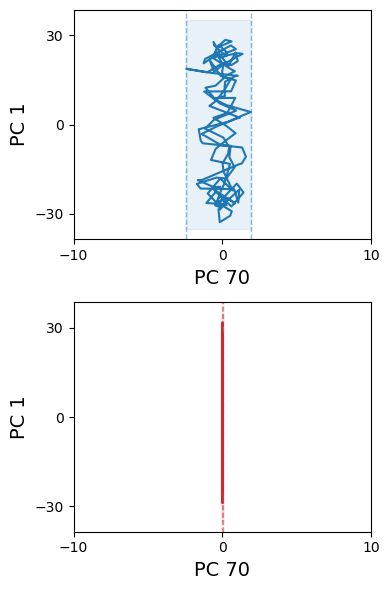

In [121]:
y_min, y_max = -35, 35

# plot projections in 2D
plt.figure(figsize=(4, 6))
plt.subplot(211)
plt.plot(proj_true[:, 2], proj_true[:, 1], c='tab:blue', label='Data')
# plt.legend(fontsize=12, loc='upper right')

# plot extent of the horizontal axis
plt.axvline(proj_true[:, 2].min(), color='tab:blue', linestyle='--', lw=1, alpha=0.5)
plt.axvline(proj_true[:, 2].max(), color='tab:blue', linestyle='--', lw=1, alpha=0.5)
plt.fill_betweenx([y_min, y_max], proj_true[:, 2].min(), proj_true[:, 2].max(),
                 color='tab:blue', alpha=0.1)
plt.xlabel('PC 70', fontsize=14)
plt.ylabel('PC 1', fontsize=14)
plt.xlim(-10, 10)
plt.xticks([-10, 0, 10])
plt.yticks([-30, 0, 30])

plt.subplot(212)
plt.plot(proj_pred[:, 2], proj_pred[:, 1], c='tab:red', label='Gaussian Model')
# plt.legend(fontsize=12, loc='upper right')
# plot extent of the horizontal axis
plt.axvline(proj_pred[:, 2].min(), color='tab:red', linestyle='--', lw=1, alpha=0.5)
plt.axvline(proj_pred[:, 2].max(), color='tab:red', linestyle='--', lw=1, alpha=0.5)
plt.fill_betweenx([y_min, y_max], proj_pred[:, 2].min(), proj_pred[:, 2].max(),
                 color='tab:red', alpha=0.1)
plt.xlabel('PC 70', fontsize=14)
plt.ylabel('PC 1', fontsize=14)
plt.xlim(-10, 10)
plt.xticks([-10, 0, 10])
plt.yticks([-30, 0, 30])
# plt.suptitle('Projections onto PC 1 and PC 18', fontsize=16)

plt.tight_layout()
plt.show()

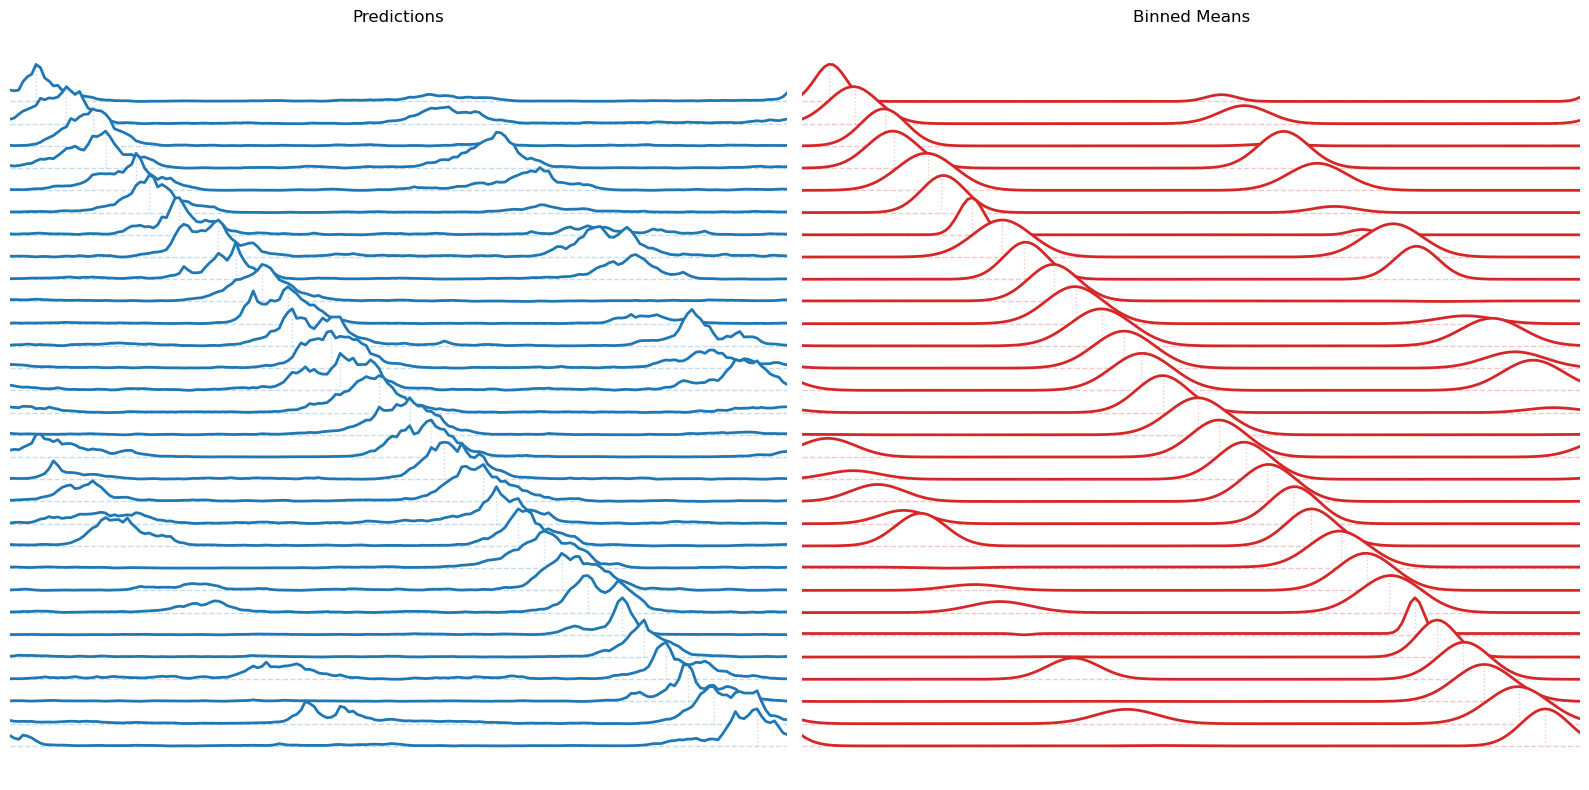

In [109]:
# select cells with widths close to each other
sigma = params[:, -1]
theta_pref = params[:, 0]
n_cells_plot = 32
n_bins = 180
good_cells = np.where((conc > 0.7) * (sigma < 0.25))[0]
cells_plot = []

for j in range(n_cells_plot):
    target_peak = j * 2 * np.pi / n_cells_plot
    closest_dist = np.min(abs(theta_pref[good_cells] - target_peak))
    close_cells = good_cells[np.abs(theta_pref[good_cells] - target_peak) < closest_dist + 0.05]
    # remove cells that have already been selected
    close_cells = [cell for cell in close_cells if cell not in cells_plot]
    # choose cell in close_cells with responses concentrated around target_peak
    # window_1_radius = 0.1
    # window_2_radius = 0.3
    # window1_mass = np.zeros(len(close_cells))
    # window2_mass = np.zeros(len(close_cells))
    # for i, cell in enumerate(close_cells):
    #     theta_c = angles[cell]
    #     resp_c = response[cell]
    #     theta_window1 = (theta_c >= target_peak - window_1_radius) & (theta_c <= target_peak + window_1_radius)
    #     window1_mass[i] = np.sum(resp_c[theta_window1]) / np.sum(theta_window1)  # window 1 mean
    #     theta_window2 = (theta_c >= target_peak - window_2_radius) & (theta_c <= target_peak + window_2_radius)
    #     theta_diff = theta_window2 & (~theta_window1)  # only consider points in window 2 that are not in window 1
    #     window2_mass[i] = np.sum(resp_c[theta_window2]) / np.sum(theta_window2)  # window 2 mean
    # decay_rate = window1_mass / window2_mass  # decay rate of the response in window 1 compared to window 2
    # # choose the cell with the highest decay rate
    # best_cell = close_cells[np.argmax(decay_rate)]
    # cells_plot.append(best_cell)

    # look at R_z and choose the best cell
    R_close = R_z[close_cells]
    curvature = np.zeros(len(close_cells))
    window_radius = 25  # radius in bins around the peak
    oscillations = np.zeros(len(close_cells))
    for i, cell in enumerate(close_cells):
        # compute the second derivative at the peak
        peak_idx = np.argmax(R_close[i])
        if peak_idx == 0 or peak_idx == R_close.shape[1] - 1:
            curvature[i] = 0
        else:
            curvature[i] = abs(R_close[i, peak_idx + 1] - 2 * R_close[i, peak_idx] + R_close[i, peak_idx - 1])
        # compute the number of oscillations in the window around the peak
        peak_idx = np.argmax(R_close[i])
        # create a mask for the radius around the peak, accounting for circular wraparound
        mask = np.zeros_like(R_close[i], dtype=bool)
        for k in range(-window_radius, window_radius + 1):
            mask[(peak_idx + k) % len(R_close[i])] = True
        # count the number of oscillations in the window.
        # an oscillation is defined as a response that is lower than the previous response in the window
        # we expect to see 1 oscillation for a good cell
        windowed_response = R_close[i][mask]
        oscillations[i] = np.sum(np.diff(windowed_response) < 0)
    # choose a cell with high curvature and low oscillations
    # print(f"position {j}: curvature = {curvature}, oscillations = {oscillations}")
    score = curvature - 0.75 * oscillations
    best_cell = close_cells[np.argmax(score)]
    cells_plot.append(best_cell)

selected_cells = np.array(cells_plot)
predictions = np.zeros((n_cells_plot, n_bins))
binned_means = np.zeros((n_cells_plot, n_bins))
angle_linspace = jnp.linspace(0, 2 * np.pi, n_bins, endpoint=False)

for i, c in enumerate(selected_cells):
    # predictions
    predictions[i] = neuron_model(angle_linspace, *params[c])
    predictions[i][predictions[i] < 0] = 0  # ensure no negative predictions
    predictions[i] = (predictions[i] - np.min(predictions[i])) / (np.max(predictions[i]) - np.min(predictions[i]))  # normalize to [0, 1]
    theta_c = angles[c]
    resp_c = response[c]

    # binned means
    # bin_counts, _ = np.histogram(theta_c, bins=n_bins, range=(0, 2 * np.pi))
    # bin_sums, _ = np.histogram(theta_c, bins=n_bins, range=(0, 2 * np.pi), weights=resp_c)
    # binned_means[i] = bin_sums / (bin_counts + 0.1)  # avoid division by zero
    # binned_means[i] = (binned_means[i] - np.min(binned_means[i])) / (np.max(binned_means[i]) - np.min(binned_means[i])) # normalize to [0, 1]
    theta, matern_mean, _ = matern_quasi_circular(
        stim=theta_c, resp=resp_c, theta_samples=n_bins,
        matern_length_scale=3.5, matern_nu=0.5,
        observation_noise_factor=0.05,
    )
    binned_means[i] = (matern_mean - np.min(matern_mean)) / (np.max(matern_mean) - np.min(matern_mean))  # normalize to [0, 1]


# 1. Sort by theta_pref in DESCENDING order.
# This makes sorted_preds[0] the bottom-most curve on the plot.
sort_idx = np.argsort(theta_pref[selected_cells])[::-1] # IMPORTANT: Descending sort
sorted_preds = predictions[sort_idx]
sorted_means = binned_means[sort_idx]

# 2. pick spacing
amplitude = sorted_preds.max() - sorted_preds.min()
offset = amplitude * 0.6

# 3. figure
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
fig.patch.set_facecolor('white')
for a in ax:
    a.set_facecolor('white')

# 4. mask & plot each ridge for predictions
radius = n_bins // 4  # radius in bins around the peak

# Iterate from i=0 to n_cells_plot-1.
# With descending sort, i=0 is the bottom-most curve, i=1 is the next one up, etc.
# We assign a decreasing zorder as i increases.
for i in range(n_cells_plot): 
    y = sorted_preds[i]
    baseline = i * offset 
    y_off = y + baseline

    # Find the peak index
    peak_idx = np.argmax(y)
    
    # Create a mask for the radius around the peak, accounting for circular wraparound
    mask = np.zeros_like(y, dtype=bool)
    for k in range(-radius, radius + 1):
        mask[(peak_idx + k) % len(y)] = True
    # circular shift the mask to get the antipodal peak
    mask_antipodal = np.roll(mask, len(y) // 2)
    mask = mask + mask_antipodal  # Combine both masks
    
    y_off_masked = np.copy(y_off)
    y_off_masked[~mask] = np.nan

    if i == 0 or i == n_cells_plot - 1:
        continue  # Skip the first and last curves for the baseline plot

    # Zorder: n_cells_plot - i gives a decreasing zorder as i increases.
    # Higher zorder for the bottom curves.
    # We use (n_cells_plot - 1 - i) * 2 or similar to ensure unique zorders.
    current_zorder = (n_cells_plot - 1 - i) * 3 

    # Draw the filled area with white
    ax[1].fill_between(angle_linspace, baseline, y_off_masked, color='white', zorder=current_zorder + 2)

    # Draw the ridge line on top of the fill
    ax[1].plot(angle_linspace, y_off_masked,
               color='tab:red', linewidth=2.0, zorder=current_zorder + 3)
    
    # Plot the baseline
    ax[1].plot(angle_linspace, baseline * np.ones_like(angle_linspace), color='tab:red', linewidth=1, linestyle='--', zorder=current_zorder + 3, alpha=0.25)

    # add a vertical line at the peak of each curve, starting at the baseline
    peak_angle = angle_linspace[peak_idx]
    second_peak_angle = (peak_angle + np.pi) % (2 * np.pi)

    # Plot the vertical line at the peak angle and its antipodal point
    ax[1].plot([peak_angle, peak_angle], [baseline, y_off_masked[peak_idx]], color='tab:red', linewidth=1, linestyle=':', zorder=current_zorder + 3, alpha=0.25)
    # ax[0].plot([second_peak_angle, second_peak_angle], [baseline, y_off_masked[(peak_idx + len(y) // 2) % len(y)]],
    #             color='tab:red', linewidth=1, linestyle=':', zorder=current_zorder + 3)
    
    # # plot black dot at peak angle and second peak angle
    # ax[0].plot(peak_angle, baseline, 'ko', markersize=6, zorder=current_zorder + 3, alpha=0.5)
    # ax[0].plot(second_peak_angle, baseline, 'ko', markersize=6, zorder=current_zorder + 3, alpha=0.5)


# 5. mask & plot each ridge for binned means
for i in range(n_cells_plot): 
    y = sorted_means[i]
    baseline = i * offset
    y_off = y + baseline

    # Find the peak index
    peak_idx = np.argmax(y)
    
    # Create a mask for the radius around the peak, accounting for circular wraparound
    mask = np.zeros_like(y, dtype=bool)
    for k in range(-radius, radius + 1):
        mask[(peak_idx + k) % len(y)] = True
    # circular shift the mask to get the antipodal peak
    mask_antipodal = np.roll(mask, len(y) // 2)
    mask = mask + mask_antipodal  # Combine both masks

    y_off_masked = np.copy(y_off)
    y_off_masked[~mask] = np.nan

    if i == 0 or i == n_cells_plot - 1:
        continue  # Skip the first and last curves for the baseline plot
    
    current_zorder = (n_cells_plot - 1 - i) * 3 # Same zorder calculation

    # Draw the filled area with white
    ax[0].fill_between(angle_linspace, baseline, y_off_masked, color='white', zorder=current_zorder + 2)

    # Draw the ridge line on top of the fill
    ax[0].plot(angle_linspace, y_off_masked, color='tab:blue', linewidth=2.0, zorder=current_zorder + 3)
    
    # Plot the baseline
    ax[0].plot(angle_linspace, baseline * np.ones_like(angle_linspace), color='tab:blue', linewidth=1, linestyle='--', zorder=current_zorder + 3, alpha=0.25)

    # add a vertical line at the peak of each curve, starting at the baseline
    peak_angle = angle_linspace[peak_idx]
    second_peak_value = np.max(y[mask_antipodal])
    second_peak_index = np.where(y == second_peak_value)[0][0]
    second_peak_angle = angle_linspace[second_peak_index]

    # Plot the vertical line at the peak angle and its antipodal point
    ax[0].plot([peak_angle, peak_angle], [baseline, y_off_masked[peak_idx]], color='tab:blue', linewidth=1, linestyle=':', zorder=current_zorder + 3, alpha=0.25)
    # ax[1].plot([second_peak_angle, second_peak_angle], [baseline, y_off_masked[second_peak_index]],
    #             color='tab:blue', linewidth=1, linestyle=':', zorder=current_zorder + 3)

    # # plot black dot at peak angle and peak angle + np.pi
    # ax[1].plot(peak_angle, baseline, 'ko', markersize=6, zorder=current_zorder + 3, alpha=0.5)
    # ax[1].plot((peak_angle + np.pi) % (2 * np.pi), baseline, 'ko', markersize=6, zorder=current_zorder + 3, alpha=0.5)


# 6. (optional) clean up axes
for a in ax:
    a.set_xlim(angle_linspace.min(), angle_linspace.max())
    a.set_xticks([]); a.set_yticks([])
    for spine in a.spines.values():
        spine.set_visible(False)

ax[0].set_title('Predictions')
ax[1].set_title('Binned Means')

plt.tight_layout()
plt.show()